# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [27]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.545539
sanity check: 2.302585


## Inline Question 1:
**Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** This is because the softmax loss function outputs the approximate probability of the outcome of the label scores over all scores. If the weights are random, it should be equivalent to picking 1 out of 10 at random.


In [41]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.520080 analytic: -0.520075, relative error: 3.979034e-06
numerical: 6.763525 analytic: 6.763526, relative error: 1.194378e-07
numerical: 3.170853 analytic: 3.170858, relative error: 6.965789e-07
numerical: 5.029454 analytic: 5.029458, relative error: 3.645042e-07
numerical: -12.287985 analytic: -12.287978, relative error: 2.810755e-07
numerical: 3.737887 analytic: 3.737890, relative error: 3.420428e-07
numerical: 8.678035 analytic: 8.678038, relative error: 1.476310e-07
numerical: -18.046118 analytic: -18.046111, relative error: 1.828183e-07
numerical: 9.283814 analytic: 9.283816, relative error: 1.172510e-07
numerical: 1.715070 analytic: 1.715075, relative error: 1.476605e-06
numerical: -10.154182 analytic: -10.154176, relative error: 2.618243e-07
numerical: 8.348545 analytic: 8.348548, relative error: 1.769502e-07
numerical: -9.548582 analytic: -9.548577, relative error: 2.708950e-07
numerical: 10.065860 analytic: 10.065863, relative error: 1.661514e-07
numerical: -19.8

In [65]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.545539e+00 computed in 0.142249s
vectorized loss: 2.545539e+00 computed in 0.005621s
Loss difference: 0.000000
Gradient difference: 0.000000


In [118]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

#Trial 1
#learning_rates = [np.random.uniform(1e-7, 1e-6) for _ in range(6)] #[1e-7, 5e-7]
#regularization_strengths =  [np.random.uniform(2.5e3, 5e5) for _ in range(6)] #[2.5e4, 5e4]

#Trial 2
# mid_lr = 7.883218e-07
# learning_rates = [np.random.uniform(mid_lr * 0.5, mid_lr * 1.5) for _ in range(6)] #[1e-7, 5e-7]
# mid_reg = 4.460189e+05
# regularization_strengths =  [np.random.uniform(mid_reg * 0.5, mid_reg * 1.5) for _ in range(6)] #[2.5e4, 5e4]
# num_iter = 10

#Trial 3
# mid_lr = 5.475168e-07
# learning_rates = [np.random.uniform(mid_lr * 0.2, mid_lr * 2.0) for _ in range(8)] #[1e-7, 5e-7]
# mid_reg = 3.441457e+05
# regularization_strengths =  [np.random.uniform(mid_reg * 0.2, mid_reg * 2.0) for _ in range(8)] #[2.5e4, 5e4]
# num_iter = 20

# Trial 4

# learning_rates = []
# for exponent in range(3, 9):
#     for _ in range(2):
#         learning_rates.append(np.random.uniform(10**(-exponent), 10**(-exponent+1)))

# regularization_strengths = []
# for exponent in range(2, 6):
#     for _ in range(2):
#         regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
# print(learning_rates)
# print(regularization_strengths)
# num_iter = 12

# Trial 5

# learning_rates = []
# for exponent in range(6, 8):
#     for _ in range(5):
#         learning_rates.append(np.random.uniform(10**(-exponent), 10**(-exponent+1)))

# regularization_strengths = []
# for exponent in range(2, 6):
#     for _ in range(3):
#         regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
# print(learning_rates)
# print(regularization_strengths)
# num_iter = 16

# Trial 6

# learning_rates = []
# for exponent in range(6, 7):
#     for _ in range(8):
#         learning_rates.append(np.random.uniform(8*10**(-exponent-1), 2*10**(-exponent)))

# regularization_strengths = []
# for exponent in range(4, 6):
#     for _ in range(2):
#         regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
# print(learning_rates)
# print(regularization_strengths)
# num_iter = 32

# Trial 7

# learning_rates = []
# for _ in range(10):
#     learning_rates.append(np.random.uniform(1.507027e-06 * 0.8, 1.755822e-06 * 1.2))

# regularization_strengths = []
# mid_reg = 3.052779e+04
# for _ in range(4):
#     regularization_strengths.append(np.random.uniform(mid_reg * 0.8, mid_reg * 1.2))
# print(learning_rates)
# print(regularization_strengths)
# num_iter = 64

#Trial 8

# learning_rates = []
# mid_lr = 1.290830e-06
# for _ in range(10):
#     learning_rates.append(np.random.uniform(mid_lr * 0.8, mid_lr * 1.2))

# regularization_strengths = []
# mid_reg = 2.793669e+04
# for _ in range(4):
#     regularization_strengths.append(np.random.uniform(mid_reg * 0.8, mid_reg * 1.2))
# print(learning_rates)
# print(regularization_strengths)
# num_iter = 200

#Trial 9

learning_rates = [1.523365e-06, 1.274630e-06]
regularization_strengths = [2.340966e+04, 2.720612e+04]

num_iter = 800

from cs231n.classifiers.softmax import softmax_loss_vectorized

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        temp_softmax = Softmax()
        losses = temp_softmax.train(X_train,
                                        y_train,
                                        learning_rate=learning_rate,
                                        reg=regularization_strength,
                                        num_iters=num_iter,
                                        batch_size=200,
                                        verbose=True
                                       )
        
        y_train_pred = temp_softmax.predict(X_train)
        train_acc = np.mean(y_train_pred == y_train)
        
        y_val_pred = temp_softmax.predict(X_val)
        val_acc = np.mean(y_val_pred == y_val)
        
        if best_val < val_acc:
            best_val = val_acc
            best_softmax = temp_softmax
        results[(learning_rate, regularization_strength)] = (train_acc, val_acc)
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 800: loss 719.141245
iteration 100 / 800: loss 2.108787
iteration 200 / 800: loss 2.124646
iteration 300 / 800: loss 2.086873
iteration 400 / 800: loss 2.098172
iteration 500 / 800: loss 2.159201
iteration 600 / 800: loss 2.093112
iteration 700 / 800: loss 2.084439
iteration 0 / 800: loss 853.220812
iteration 100 / 800: loss 2.141216
iteration 200 / 800: loss 2.105704
iteration 300 / 800: loss 2.104083
iteration 400 / 800: loss 2.112678
iteration 500 / 800: loss 2.107261
iteration 600 / 800: loss 2.126322
iteration 700 / 800: loss 2.121291
iteration 0 / 800: loss 723.743457
iteration 100 / 800: loss 2.113925
iteration 200 / 800: loss 2.053720
iteration 300 / 800: loss 2.124728
iteration 400 / 800: loss 2.108736
iteration 500 / 800: loss 2.051341
iteration 600 / 800: loss 2.116596
iteration 700 / 800: loss 2.057888
iteration 0 / 800: loss 840.867382
iteration 100 / 800: loss 2.111860
iteration 200 / 800: loss 2.133866
iteration 300 / 800: loss 2.143685
iteration 400 / 800:

In [119]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.343000


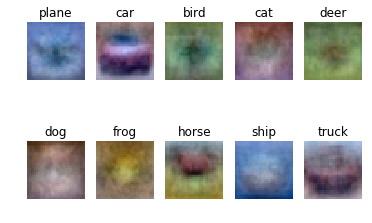

In [120]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])